In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
from torchvision import transforms

from torch.utils.data import RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
from collections import defaultdict
from albumentations import (
    HorizontalFlip,
    VerticalFlip,
    Compose,
    RandomRotate90,
    ElasticTransform,
    GridDistortion, 
    OpticalDistortion,
    RandomGamma
)

from metrics import dice
from data import NeuronSegmDataset

from torch import nn
import torch

from encoders import ResNetEncoders
from unet import UNet

def tonp(t):
    return t.detach().cpu().numpy()
    
def process_batch(b):
    X, y  = b
    X = X.to(DEVICE)
    y = torch.tensor(y, dtype=torch.float).to(DEVICE)
    return X, y

def prediction_to_numpy(pred):
    return pred.sigmoid().detach().cpu().numpy() 

def evaluate(model, loader, threshold):
    model = model.eval()
    for b in loader:
        X, y = process_batch(b)
        X = X.repeat(1, 3, 1, 1)
        res = model(X)
    val_loss = nn.BCEWithLogitsLoss()(res, y)
    pred_Y, real_Y = prediction_to_numpy(res) > threshold, tonp(y)> threshold
    dices = []
    for ypred, yreal in zip(pred_Y, real_Y):
        dices.append(dice(ypred, yreal))
    return np.array(dices).mean(), val_loss.detach().cpu().numpy()


In [11]:
neuron_target = './train-labels.tif'
neuron_train = './train-volume.tif'


trans_train = transforms.Compose([transforms.Resize(192), 
                                  transforms.ToTensor()])
trans_test = transforms.Compose([transforms.Resize(192), 
                                 transforms.ToTensor()])

aug = Compose([RandomGamma(), 
               VerticalFlip(), 
               HorizontalFlip(),
               RandomRotate90(), 
               GridDistortion(),
               ElasticTransform(),
               OpticalDistortion(distort_limit=1, shift_limit=1)])


train_ds = NeuronSegmDataset(neuron_train, neuron_target, image_transform=trans_train, augmenter=aug)
test_ds = NeuronSegmDataset(neuron_train, neuron_target, image_transform=trans_test)
train_ds_val = NeuronSegmDataset(neuron_train, neuron_target, image_transform=trans_train)


random_training_sampler = RandomSampler(train_ds)
train_idx , test_idx = train_test_split(range(len(train_ds)), test_size=0.15)

random_sampler_train = RandomSampler(train_idx)
sampler_test = SequentialSampler(test_idx)

training_data_loader = DataLoader(train_ds, batch_size=1, num_workers=1, sampler=random_training_sampler)
test_data_loader = DataLoader(test_ds, batch_size=6, num_workers=1, sampler=sampler_test)
train_ds_val_loader = DataLoader(train_ds_val, batch_size=6, num_workers=1, sampler=random_training_sampler)

# unet = OriginalUnet(n_classes=1,depth=3, padding=True, up_mode='upsample').cuda()
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

resnet = ResNetEncoders(18, pretrained=True).to(DEVICE)
unet = UNet(resnet, 1).to(DEVICE)

optim = torch.optim.Adam(unet.parameters())
#epochs = 1000
epochs = 200
loss_bce = nn.BCEWithLogitsLoss()
loss = 0
THRESHOLD = 0.5
history = defaultdict(list)

/opt/conda/envs/dsr/lib/python3.6/site-packages/ipykernel_launcher.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


epoch 0
dice 0.8721610334946434
loss 0.48700222
train_dice 0.8929033040720649
train_loss 0.4645098
epoch 1
dice 0.9077565472974092
loss 0.36673132
train_dice 0.9134520430439507
train_loss 0.3541489
epoch 2
dice 0.9169106689142014
loss 0.34353694
train_dice 0.9244608486684629
train_loss 0.32164723
epoch 3
dice 0.8984131289205003
loss 0.34359336
train_dice 0.9039909894852108
train_loss 0.3369274
epoch 4
dice 0.9287719851448835
loss 0.2948981
train_dice 0.931684053947721
train_loss 0.27940768
epoch 5
dice 0.9301904783391406
loss 0.294206
train_dice 0.9348016531518684
train_loss 0.2743954
epoch 6
dice 0.9356381302470597
loss 0.27821517
train_dice 0.9423955513856548
train_loss 0.2527654
epoch 7
dice 0.9294797329363693
loss 0.29882994
train_dice 0.9366971895746047
train_loss 0.26971957
epoch 8
dice 0.9300680189153765
loss 0.28232992
train_dice 0.9370431809983312
train_loss 0.26604316
epoch 9
dice 0.9267965252784007
loss 0.29122216
train_dice 0.9358116237307265
train_loss 0.26925105
epoch 10


epoch 82
dice 0.9417944413387135
loss 0.25357708
train_dice 0.9456722922846619
train_loss 0.23483485
epoch 83
dice 0.9438642441735479
loss 0.258756
train_dice 0.9408107525595137
train_loss 0.26230904
epoch 84
dice 0.9381561013365365
loss 0.25057852
train_dice 0.9448123547216672
train_loss 0.2279479
epoch 85
dice 0.9459291772300631
loss 0.23921992
train_dice 0.9466268524779146
train_loss 0.23008357
epoch 86
dice 0.9464512961442191
loss 0.24171732
train_dice 0.9515904011512021
train_loss 0.21979296
epoch 87
dice 0.946774464265715
loss 0.23999172
train_dice 0.9524740466355351
train_loss 0.21150851
epoch 88
dice 0.9427163932776519
loss 0.24811843
train_dice 0.9417393064592914
train_loss 0.24952231
epoch 89
dice 0.9366507418577624
loss 0.2743491
train_dice 0.940330281438678
train_loss 0.26061767
epoch 90
dice 0.9430728131725911
loss 0.24865496
train_dice 0.9475047704485892
train_loss 0.23128816
epoch 91
dice 0.9434541303781232
loss 0.24292587
train_dice 0.9487777673929959
train_loss 0.21977

epoch 164
dice 0.9394105843147763
loss 0.25745994
train_dice 0.940415127545699
train_loss 0.2538012
epoch 165
dice 0.9480740649705298
loss 0.2308634
train_dice 0.9530672923151422
train_loss 0.20983902
epoch 166
dice 0.9506211017362022
loss 0.22855742
train_dice 0.9606775976067213
train_loss 0.18991737
epoch 167
dice 0.945961890492059
loss 0.23566256
train_dice 0.9492962315561789
train_loss 0.22151804
epoch 168
dice 0.9471223863990224
loss 0.23070334
train_dice 0.9478859860190108
train_loss 0.2234904
epoch 169
dice 0.9443147542262134
loss 0.24854025
train_dice 0.9445013555356682
train_loss 0.24133292
epoch 170
dice 0.9481013520471328
loss 0.23330216
train_dice 0.946276678241777
train_loss 0.23212661
epoch 171
dice 0.9356072311863365
loss 0.25239286
train_dice 0.9429854473473555
train_loss 0.22784252
epoch 172
dice 0.9442286349740202
loss 0.25488147
train_dice 0.9455402401082816
train_loss 0.23874806
epoch 173
dice 0.9471727833897894
loss 0.23463961
train_dice 0.9506235603057916
train_lo

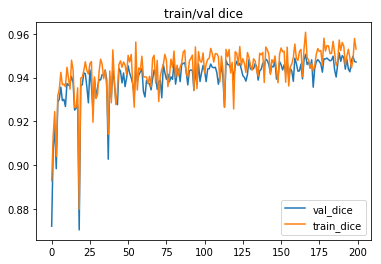

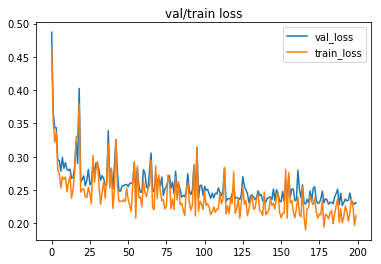

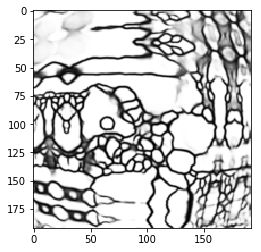

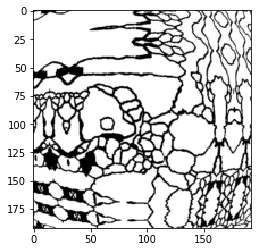

In [12]:
for i, _ in enumerate(range(epochs)):
    for batch in training_data_loader:
        X, y = process_batch(batch)
        X = X.repeat(1,3,1,1)
        prediction = unet(X)  # [N, 2, H, W]
        loss = loss_bce(prediction, y)   
        optim.zero_grad()
        loss.backward()
        optim.step()   
        
    val_mean_dice, val_loss = evaluate(unet, test_data_loader, threshold=THRESHOLD)
    train_mean_dice, train_loss = evaluate(unet, train_ds_val_loader, threshold=THRESHOLD)
    
    print("epoch", i)
    print('dice', val_mean_dice)
    print('loss', val_loss)
    print('train_dice', train_mean_dice)
    print('train_loss', train_loss)
    unet.train()
    
    history['val_dice'].append(val_mean_dice)
    history['val_loss'].append(val_loss)
    history['train_dice'].append(train_mean_dice)
    history['train_loss'].append(train_loss)
    
    
df = pd.DataFrame(history)

plt.figure()
plt.title('train/val dice')
plt.plot(df.val_dice)
plt.plot(df.train_dice)
plt.legend(['val_dice', 'train_dice'])
plt.figure()
plt.title('val/train loss')
plt.plot(df.val_loss)
plt.plot(df.train_loss)
plt.legend(['val_loss', 'train_loss'])


plt.figure()
plt.imshow(prediction[0][0].detach().sigmoid().cpu().numpy(), cmap='gray')
plt.figure()
plt.imshow(y.detach()[0][0].cpu().numpy(), cmap='gray')

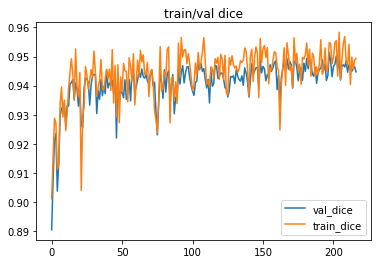

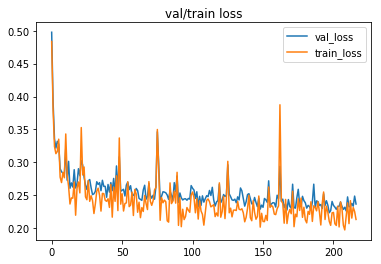

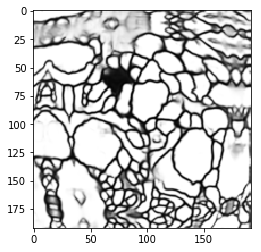

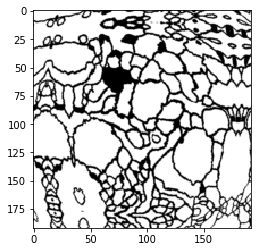